Creating another variation on the initial data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("C:\\Users\\bkb3\\Accident_Data_Preprocessing\\Data_Raw\\mdtraffic.csv")

## Drop columns unlikely to be useful

Too focused on timing or too fine grained or unique

In [3]:
df.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [4]:
df.drop(["ID","Source","Country"],axis=1,inplace=True) # drop clearly unneeded columns

In [5]:
df["Zipcode"] = df.Zipcode.apply(lambda x: str(x).split("-")[0]) # fix zipcodes so that they are all 5 digit

In [6]:
df.drop(["End_Time","End_Lat","End_Lng"],axis=1,inplace=True) #can't know these things before it happens

In [7]:
df.drop(["Start_Lat","Start_Lng","State","City"],axis=1,inplace=True)# so much of location data is redundant and correlated

In [8]:
df.drop(["Timezone","Weather_Timestamp","Airport_Code","Description"],axis=1,inplace=True)

In [9]:
df.drop(["Start_Time","Zipcode","County"],axis=1,inplace=True)

## Street Type

In [10]:
df = df[~df.Street.str.contains("Francis Scott Key Bridge",na=False)]

In [11]:
print(df.Street.value_counts().shape)
df.Street.value_counts()

(7620,)


Street
I-95 S               5747
I-95 N               5662
Capital Beltway S    4052
Capital Beltway N    3224
Capital Beltway W    2892
                     ... 
87th Ave                1
Haverhill Rd            1
N Dundalk Ave           1
Freedom Way W           1
 Spa Rd                 1
Name: count, Length: 7620, dtype: int64

In [12]:
def nsew(x,r):
    if x[-1] in ["N","S","E","W"]:
        r= r+x[-1]
    return r

In [13]:
def street_type(x):
    if "Tunl" in x or "Tunnel" in x:
        return "Tunnel"#nsew(x,"Tunnel")
    if "I-" in x:
        return "Interstate"
    if " Dr " in x or " Ave " in x or " Rd " in x or " Xing" in x or " Way " in x:
        return "local"
    if "Beltway" in x:
        return "Beltway"
    if "US-" in x[:4] or "MD-" in x[:4] or "Expy" in x:
        return "Highway"
    if "Hwy" in x or "Fwy" in x or "Highway" in x or "Route" in x or "Connector" in x or "Byp" in x or "Bypass" in x or "Gtwy" in x or "Brg" in x or "Trwy" in x:
        return "Highway"
    if x[-2:] in ["St","Pl","Dr","Sq"]:
        return "local"
    if "Ln" in x or "Rd" in x or "Ct" in x:
        return "local"
    if x[-3:] in ["Way","Cir","Ter","Trl","Plz","Aly","Grn","way","Ext"]:
        return "local"
    if "Ave" in x[-5:] or " Blvd" in x or " Pike" in x or "Pkwy" in x or "Crse" in x or "Alameda" in x:
        return "large_local"
    if "Garth" in x or "Spell" in x or "Psge" in x or "Chase" in x or "Cutoff" in x or "Spire" in x:
        return "local"
    if "Overlook" in x or "Battlefield" in x or "Cemetery" in x or "Park" in x or "Base" in x or "Concourse" in x or "Memorial" in x:
        return "special"
    if "Loop" in x or "Greenway" in x or "West" in x or "ville" in x or "wood" in x:
        return "local"
    
    return x

In [14]:
df["Street"] = df["Street"].astype(str)
df["Street"] = df.Street.apply(street_type)

In [15]:
df=df.loc[~df.Street.str.contains("special")]

In [16]:
df.Street.value_counts()

Street
Interstate                            38841
local                                 34389
large_local                           24719
Highway                               24649
Beltway                               14316
                                      ...  
Harriet Tubman Underground RR Bywy        1
4B                                        1
13C                                       1
 Fraternity Row                           1
US 50                                     1
Name: count, Length: 126, dtype: int64

## Weather Condition

In [17]:
df["Weather_Condition"].value_counts()

Weather_Condition
Fair                       38849
Cloudy                     18089
Mostly Cloudy              14777
Partly Cloudy               9907
Clear                       9385
                           ...  
Drizzle and Fog                2
Light Snow Shower              1
Heavy Ice Pellets              1
Showers in the Vicinity        1
Squalls / Windy                1
Name: count, Length: 71, dtype: int64

In [18]:
df = df.loc[(df.Weather_Condition != "Sand")] # too few values

In [19]:
# missing values count as a float
# change to "unknown" instead. Later we can decide if we want to keep
df["Weather_Condition"] = df["Weather_Condition"].fillna("unknown")

In [20]:
df["Weather_Condition"] = df["Weather_Condition"].apply(lambda x: "None" if "N/A" in x else x)

In [21]:
df["Weather_Condition"]=df["Weather_Condition"].apply(lambda x: "Windy" if "Windy" in x else x)

In [22]:
def mapping_1(x):
    tomap = {"Light Drizzle":"Drizzle",
            "Light Rain with Thunder":"Light Thunderstorms and Rain",
            "Thunder in the Vicinity":"Thunder",
            "Heavy Drizzle":"Rain",
            "Mist":"Fog",
            "Light Freezing Drizzle":"Light Freezing Rain"}
    if x in tomap:
        return tomap[x]
    return x

In [23]:
def mapping_2(x):
    tomap = {"Light Rain Shower":"Drizzle",
             "Light Rain":"Drizzle",
            "Light Ice Pellets":"Ice Pellets",
            "Shallow Fog":"Fog"}
    if x in tomap:
        return tomap[x]
    return x

In [24]:
def mapping_3(x):
    tomap = {"Heavy Ice Pellets":"Ice Pellets",
            "Drizzle and Fog":"Fog",
            "Patches of Fog":"Fog",
            "Heavy Snow":"Snow",
            "Heavy Thunderstorms and Rain":"Thunderstorms",
            "T-Storm":"Thunderstorms",
            "Heavy T-Storm":"Thunderstorms",
            "Thunderstorms and Rain":"Thunderstorms"}
    if x in tomap:
        return tomap[x]
    return x

In [25]:
def mapping_4(x):
    tomap = {"Light Snow Shower":"Snow",
            "Light Snow":"Snow",
            "Light Rain Showers":"Drizzle",
            "Light Thunderstorms and Rain":"Thunderstorms"}
    if x in tomap:
        return tomap[x]
    return x

In [26]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_1)                        

In [27]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_2)

In [28]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_3)

In [29]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_4)

In [30]:
df.Weather_Condition.value_counts()

Weather_Condition
Fair                       38849
unknown                    26830
Cloudy                     18089
Mostly Cloudy              14777
Partly Cloudy               9907
Clear                       9385
Overcast                    5943
Drizzle                     5516
Scattered Clouds            3145
Snow                        1773
Fog                         1594
Rain                        1382
Windy                       1048
Wintry Mix                   418
Heavy Rain                   385
Haze                         365
Thunderstorms                333
Thunder                      158
Light Freezing Rain          139
Snow and Sleet                59
None                          43
Thunderstorm                  31
Ice Pellets                   29
Small Hail                    29
Light Sleet                   26
Sleet                         25
Hail                          14
Heavy Sleet                   13
Light Freezing Fog            10
Light Snow and Sleet     

None and Light Sleet have almost no rows will values, drop them.
Light Freezing Fog has 10 rows. Change to Fog.
Leave others for now. Will need to decide if further combinations are necessary.

In [31]:
df = df.loc[(df.Weather_Condition != "None") & (df.Weather_Condition != "Light Sleet")]

In [32]:
df=df.reset_index(drop=True)

In [33]:
df.shape

(140268, 29)

## Wind Direction

In [34]:
# Can decide later whether to keep or remove rows with unknown values
df["Wind_Direction"] = df.Wind_Direction.fillna("unknown")

In [35]:
df.Wind_Direction.value_counts()

Wind_Direction
CALM        22463
unknown     20147
WNW          8281
North        7828
NW           7672
Calm         7425
S            6370
W            6224
NNW          5692
SSW          5230
N            4643
SW           4328
SSE          4007
SE           3652
WSW          3632
NNE          3551
NE           3243
ENE          2972
E            2769
ESE          2582
West         2150
VAR          2088
South        1600
East         1022
Variable      697
Name: count, dtype: int64

In [36]:
# Basic cleanup of alternative spellings
def wind_map(x):
    tomap = {"CALM":"Calm","South":"S","West":"W","North":"N","East":"E","VAR":"Variable"}
    if x in tomap:
        return tomap[x]
    return x

In [37]:
# Less fine grained values
def wind_2(x):
    tomap = {"WNW":"NW","NNW":"NW","SSW":"SW","SSE":"SE","WSW":"SW","NNE":"NE","ENE":"NE","ESE":"SE"}
    if x in tomap:
        return tomap[x]
    return x

In [38]:
df["Wind_Direction"] = df.Wind_Direction.apply(wind_map)

In [39]:
df["Wind_Direction"] = df.Wind_Direction.apply(wind_2)

In [40]:
df.Wind_Direction.value_counts()

Wind_Direction
Calm        29888
NW          21645
unknown     20147
SW          13190
N           12471
SE          10241
NE           9766
W            8374
S            7970
E            3791
Variable     2785
Name: count, dtype: int64

## Missing Values: drop columns

In [41]:
df.columns

Index(['Severity', 'Distance(mi)', 'Street', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [42]:
df.shape

(140268, 29)

In [43]:
df.isna().sum()

Severity                     0
Distance(mi)                 0
Street                       0
Temperature(F)           15672
Wind_Chill(F)            47532
Humidity(%)              15786
Pressure(in)             14488
Visibility(mi)           27400
Wind_Direction               0
Wind_Speed(mph)          34239
Precipitation(in)        49440
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Roundabout                   0
Station                      0
Stop                         0
Traffic_Calming              0
Traffic_Signal               0
Turning_Loop                 0
Sunrise_Sunset             286
Civil_Twilight             286
Nautical_Twilight          286
Astronomical_Twilight      286
dtype: int64

In [44]:
# half of the rows are missing wind chill. Better to just drop the column
df.drop(["Wind_Chill(F)"],axis=1,inplace=True)

In [45]:
# half of the rows are missing precipitation, and weather condition already
# covers that situation more or less. So drop
df.drop(["Precipitation(in)"],axis=1,inplace=True)

<Axes: >

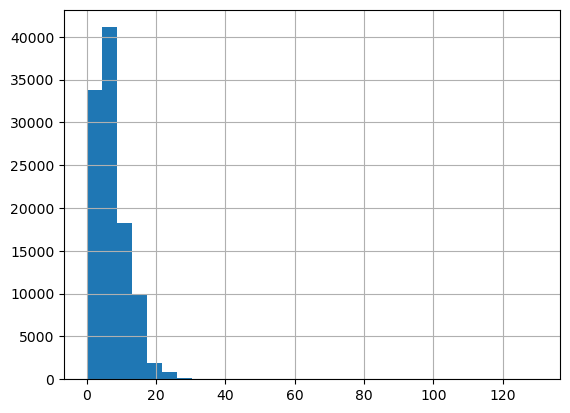

In [46]:
df["Wind_Speed(mph)"].hist(bins=30)

In [47]:
df[df["Wind_Speed(mph)"] > 40].shape[0]

18

Wind speed has a significant number of missing values. It is also a fairly tight distribution other than 11 values that are larger. Although wind speed could be useful in predicting severity, it may not be worth keeping in this situation. I think we try without it first.

In [48]:
df.drop(["Wind_Speed(mph)"],inplace=True,axis=1)

In [49]:
df.isna().sum()

Severity                     0
Distance(mi)                 0
Street                       0
Temperature(F)           15672
Humidity(%)              15786
Pressure(in)             14488
Visibility(mi)           27400
Wind_Direction               0
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Roundabout                   0
Station                      0
Stop                         0
Traffic_Calming              0
Traffic_Signal               0
Turning_Loop                 0
Sunrise_Sunset             286
Civil_Twilight             286
Nautical_Twilight          286
Astronomical_Twilight      286
dtype: int64

In [50]:
df.dropna().shape

(111309, 26)

It looks like dropping NA values doesn't remove too many rows, there must be rows with multiple NA values. So let's drop NA rows.

In [51]:
df.dropna(inplace=True)

## Twilights

We don't need four different twilights.

In [52]:
df.columns

Index(['Severity', 'Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')

In [53]:
df.drop(['Civil_Twilight','Nautical_Twilight', 'Astronomical_Twilight'],inplace=True,axis=1)

## Any columns have too little info?

In [54]:
for col in ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop']:
    print(df[col].value_counts())

Amenity
False    110672
True        637
Name: count, dtype: int64
Bump
False    111290
True         19
Name: count, dtype: int64
Crossing
False    104708
True       6601
Name: count, dtype: int64
Give_Way
False    111016
True        293
Name: count, dtype: int64
Junction
False    97725
True     13584
Name: count, dtype: int64
No_Exit
False    111148
True        161
Name: count, dtype: int64
Railway
False    111074
True        235
Name: count, dtype: int64
Roundabout
False    111306
True          3
Name: count, dtype: int64
Station
False    110109
True       1200
Name: count, dtype: int64
Stop
False    110020
True       1289
Name: count, dtype: int64
Traffic_Calming
False    110921
True        388
Name: count, dtype: int64
Traffic_Signal
False    98709
True     12600
Name: count, dtype: int64
Turning_Loop
False    111309
Name: count, dtype: int64


Bump, Give_Way, No_Exit, Roundabout, have almost no True values, so drop.
All values in Turning_Loop are identical, so drop.

In [55]:
df.drop(['Bump', 'Give_Way', 'No_Exit', 'Roundabout','Turning_Loop'],inplace=True,axis=1)

Will need to consider if it is worth keeping all of these or combining in some way.

In [56]:
df.columns

Index(['Severity', 'Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset'],
      dtype='object')

In [57]:
df.shape

(111309, 18)

## Examine Severity

For our project we want to wait to decide what to do about imbalance, and wait to one hot encode. Code below considers these issues, but the dataset saved is the one that exists without changing Severity or one hot encoding anything.

In [58]:
df.Severity.value_counts()

Severity
2    83497
3    18327
4     9080
1      405
Name: count, dtype: int64

In [59]:
#df.Severity = df.Severity.apply(lambda x: 2 if x == 1 else x)

In [60]:
for c in df.columns:
    print(c)

Severity
Distance(mi)
Street
Temperature(F)
Humidity(%)
Pressure(in)
Visibility(mi)
Wind_Direction
Weather_Condition
Amenity
Crossing
Junction
Railway
Station
Stop
Traffic_Calming
Traffic_Signal
Sunrise_Sunset


In [61]:
df_ohe = pd.get_dummies(df,drop_first=True)

In [62]:
df_ohe.shape

(111309, 164)

In [63]:
df_ohe.columns

Index(['Severity', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Amenity', 'Crossing', 'Junction',
       'Railway',
       ...
       'Weather_Condition_Snow', 'Weather_Condition_Snow Grains',
       'Weather_Condition_Snow and Sleet', 'Weather_Condition_Thunder',
       'Weather_Condition_Thunderstorm', 'Weather_Condition_Thunderstorms',
       'Weather_Condition_Windy', 'Weather_Condition_Wintry Mix',
       'Weather_Condition_unknown', 'Sunrise_Sunset_Night'],
      dtype='object', length=164)

In [64]:
# OPTIONAL: CODE TO MERGE CLASSES
#df_ohe['Severity']=df_ohe['Severity'].replace([1, 2], 0)
#df_ohe['Severity']=df_ohe['Severity'].replace([3, 4], 1)
#df_ohe["Severity"].value_counts()

In [65]:
def control_class_merge(df, c1, c2, c3, c4):
    df['Severity'] = df['Severity'].replace(c1, 0)
    df['Severity'] = df['Severity'].replace([c2, c3, c4], 1)
    df_c1 = df[df.Severity != 1]
    df_c2 = df[df.Severity != 0]
    df_c1.to_csv(f"control_class{c1}.csv", index = False)
    df_c2.to_csv(f"control_class{c2}_{c3}_{c4}_merge.csv", index = False)
    
    df['Severity'] = df['Severity'].replace(c2, 0)
    df['Severity'] = df['Severity'].replace([c1, c3, c4], 1)
    df_c1 = df[df.Severity != 1]
    df_c2 = df[df.Severity != 0]
    df_c1.to_csv(f"control_class{c2}.csv", index = False)
    df_c2.to_csv(f"control_class{c1}_{c3}_{c4}_merge.csv", index = False)
    
    df['Severity'] = df['Severity'].replace(c3, 0)
    df['Severity'] = df['Severity'].replace([c2, c1, c4], 1)
    df_c1 = df[df.Severity != 1]
    df_c2 = df[df.Severity != 0]
    df_c1.to_csv(f"control_class{c3}.csv", index = False)
    df_c2.to_csv(f"control_class{c2}_{c1}_{c4}_merge.csv", index = False)
    
    df['Severity'] = df['Severity'].replace(c4, 0)
    df['Severity'] = df['Severity'].replace([c2, c3, c1], 1)
    df_c1 = df[df.Severity != 1]
    df_c2 = df[df.Severity != 0]
    df_c1.to_csv(f"control_class{c4}.csv", index = False)
    df_c2.to_csv(f"control_class{c2}_{c3}_{c1}_merge.csv", index = False)

In [66]:
control_class_merge(df_ohe, 1, 2, 3, 4)